In [1]:
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, Colormap
import torch

from lasso.linear import dict_learning, dict_evaluate

# Data

Load the Omniglot dataset (using torchvision) and extract patches

In [2]:
from torchvision.datasets import Omniglot
from torchvision.transforms import ToTensor

In [3]:
dataset = Omniglot(root="/data/feinman", download=False, transform=ToTensor())

In [4]:
len(dataset)

19280

In [5]:
images = 1 - torch.stack([dataset[i][0] for i in range(len(dataset))])
images.shape

torch.Size([19280, 1, 105, 105])

In [6]:
images = F.interpolate(images, size=(40,40), mode='bilinear', align_corners=False)
images.shape

torch.Size([19280, 1, 40, 40])

In [7]:
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

def extract_patches2d(x, kernel_size=17, stride=7, padding=0):
    kernel_size = _pair(kernel_size)
    stride = _pair(stride)
    padding = _pair(padding)
    if padding != (0,0):
        x = F.pad(x, [padding[1], padding[1], padding[0], padding[0]])
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    x = x.permute(2,3,0,1,4,5).reshape(-1, *kernel_size)
    return x

def sample_patches(images, ntrain, ntest, **kwargs):
    # extract image patches
    patches = extract_patches2d(images, **kwargs)
    
    # remove empty patches
    patches = patches[patches.sum([1,2]) > 0]
    
    # select train/test examples
    assert images.size(0) >= ntrain + ntest, 'not enough data for the desired ntrain/ntest'
    idx = torch.randperm(patches.size(0))
    
    return patches[idx[:ntrain]], patches[idx[ntrain:ntrain+ntest]]

In [8]:
torch.manual_seed(924)
X_train, X_test = sample_patches(images, ntrain=10000, ntest=5000)
print(X_train.shape)
print(X_test.shape)

torch.Size([10000, 17, 17])
torch.Size([5000, 17, 17])


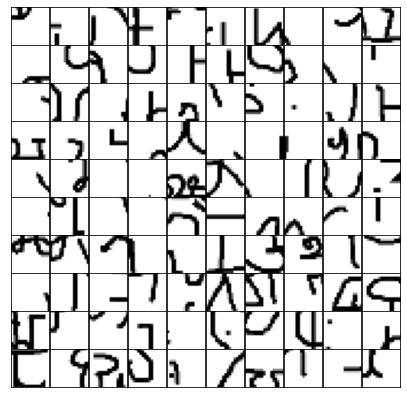

In [9]:
torch.manual_seed(399)
fig, axes = plt.subplots(10, 10, figsize=(7,7))
axes = axes.ravel()
for i in range(100):
    axes[i].imshow(X_train[i], cmap=plt.cm.binary, vmin=0, vmax=1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [11]:
# flatten patches to vectors
X_train = X_train.flatten(1)
X_test = X_test.flatten(1)

# z-score the data
xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd
X_test = (X_test - xmean) / xstd

print(X_train.shape)
print(X_test.shape)

torch.Size([10000, 289])
torch.Size([5000, 289])


# Utility code

these functions will be used for plotting, etc.

In [12]:
def plot_filter(ax, W, Wmag, cmap):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    assert isinstance(cmap, Colormap)
    W = Normalize()(W)
    img = cmap(W)
    if Wmag is not None:
        img[..., -1] = Wmag
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

def compute_magnitudes(W, pct=1.):
    mag = W.flatten(1).norm(dim=1)
    mag /= torch.quantile(mag, pct)
    return mag.clamp(0, 1)

def show_filters(W, ncol=24, magnitudes=True, mag_pct=1., size=0.7,
                 cmap='viridis', title=None, hspace=0, wspace=0):
    if W.dim() == 4 and W.size(1) == 1:
        W = W.squeeze(1)  # handle pytorch format
    n = W.size(0)
    nrow = math.ceil(n / ncol)
    Wmag = compute_magnitudes(W, mag_pct) if magnitudes else n * [None]

    fig, axes = plt.subplots(nrow, ncol, figsize=(size * ncol, size * nrow))
    axes = axes.ravel()
    for i in range(nrow * ncol):
        if i >= n:
            axes[i].set_axis_off()
            continue
        plot_filter(axes[i], W[i], Wmag[i], cmap)
    if title is not None:
        plt.suptitle(title)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.show()

In [13]:
def view_results(weight, n=None, show_norms=False, **kwargs):
    W = weight.detach().cpu().T
    norms, ix = W.norm(dim=1).sort(descending=True)
    W = W[ix].reshape(W.size(0), 17, 17)
    if n is not None:
        norms, W = norms[:n], W[:n]
        
    # show bar plot of filter norms
    if show_norms:
        norms = norms[:50]
        plt.figure(figsize=(10,3))
        plt.bar(range(len(norms)), norms)
        plt.show()
        
    # visualize filters
    show_filters(W, **kwargs)

In [14]:
def random_choice(x, n, dim=0):
    N = x.size(dim)
    ix = torch.randperm(N)[:n]
    return x.index_select(dim, ix)

# Experiments

We will compare two different dictionary learning settings:
1. constrained dictionary. The basis vectors are constrained to have unit norm
2. unconstrained dictionary. The basis vectors are unconstrained, but we place an L2 penalty on them

The `Iterated Ridge` method is memory-hungry in the default "Cholesky Factorization" mode (my GPU runs out of memory with the full dataset). Thus, we try two versions of this algorithm: 1) a version that uses the full dataset, but an approximate CG-based solver, and 2) a version with the default Cholesky solver, but only a subset of the data.

In [15]:
device = torch.device('cuda')
#device = torch.device('cpu')  # use this if no GPU available

In [16]:
torch.manual_seed(127)
X_train_sub = random_choice(X_train, 3000)
X_test_sub = random_choice(X_test, 3000)

# Constrained dictionary learning

Iterated Ridge

In [17]:
# IR v1
# conjugate gradient 
torch.manual_seed(32)
options = dict(algorithm='iter-ridge', init='ridge', maxiter=200, 
               cg=True, cg_options=dict(maxiter=200))
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, constrained=True, 
    steps=80, device=device, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:54<00:00,  1.47it/s, loss=31.6]


test loss: 32.2821


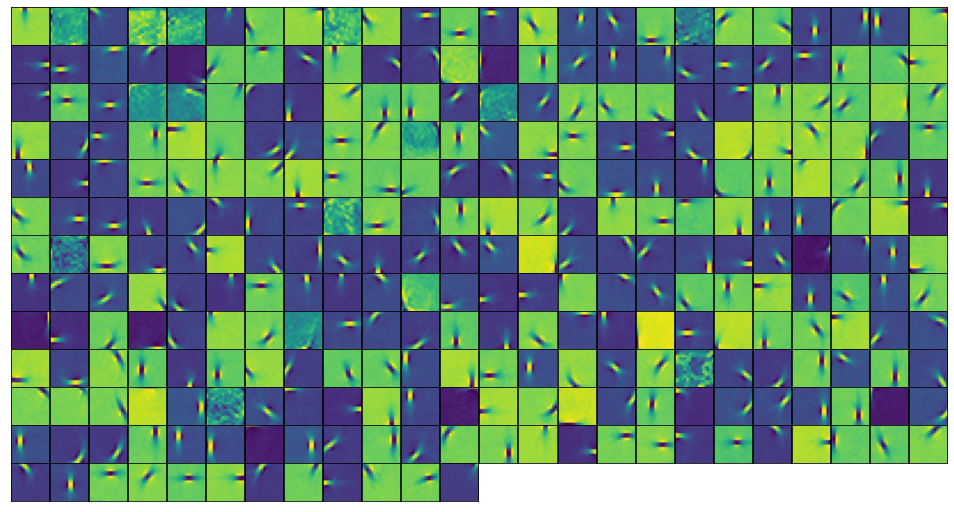

In [18]:
view_results(weight)

In [19]:
# IR v2
# use Cholesky Factorization with a data subset
torch.manual_seed(32)
options = dict(algorithm='iter-ridge', init='ridge', maxiter=200)
weight, losses = dict_learning(
    X_train_sub, 300, alpha=0.5, constrained=True, 
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test_sub, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:28<00:00,  2.83it/s, loss=29.2]


test loss: 32.8849


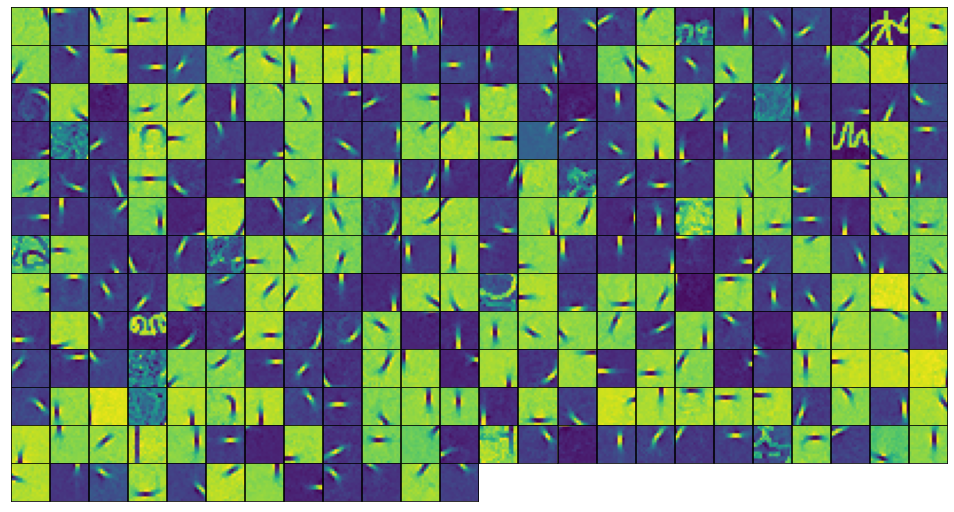

In [20]:
view_results(weight)

CD

In [21]:
torch.manual_seed(32)
options = dict(algorithm='cd', init='zero', maxiter=200)
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, constrained=True, 
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:19<00:00,  4.01it/s, loss=28.2]


test loss: 28.7506


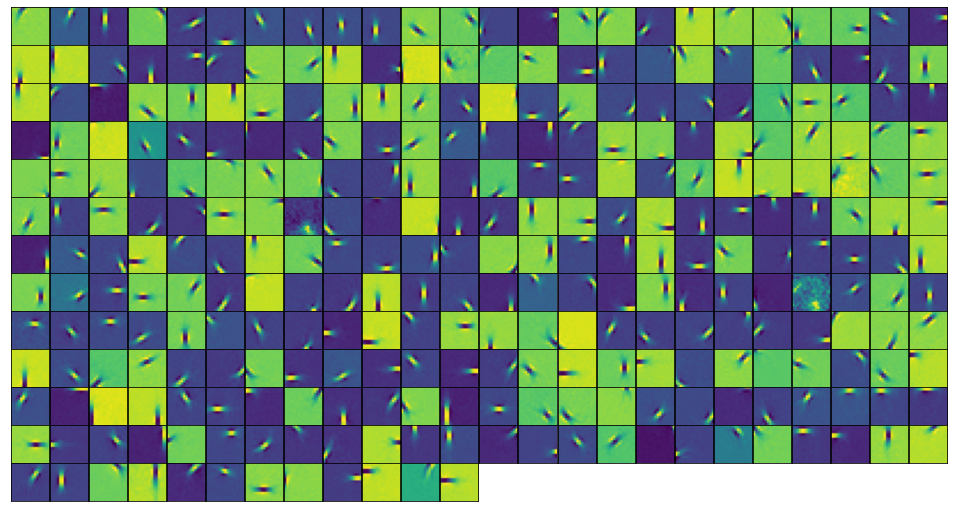

In [22]:
view_results(weight)

GPSR

In [23]:
torch.manual_seed(32)
options = dict(algorithm='gpsr', init='zero', maxiter=100)
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, constrained=True,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:32<00:00,  2.49it/s, loss=28.2]


test loss: 28.7009


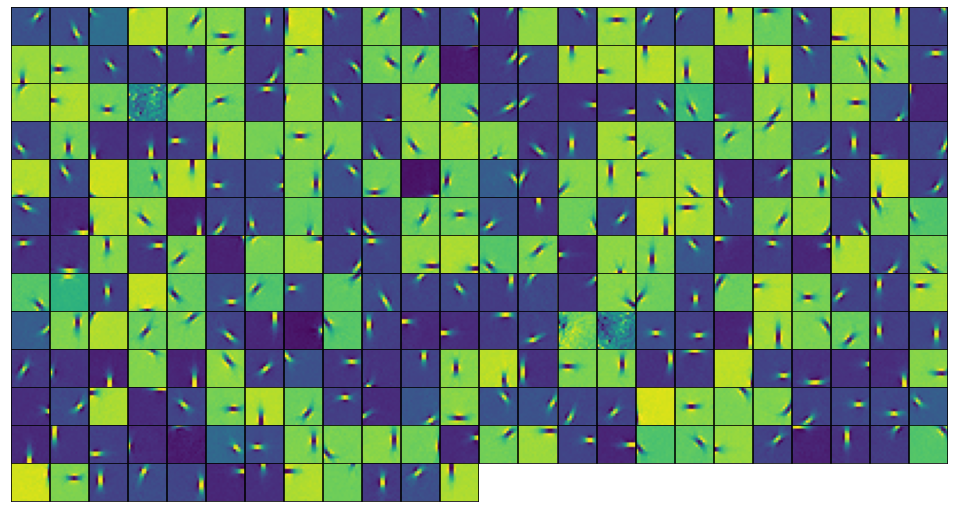

In [24]:
view_results(weight)

ISTA

In [25]:
torch.manual_seed(32)
options = dict(algorithm='ista', init='ridge', maxiter=20, fast=True, lr='auto')
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, constrained=True, 
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:09<00:00,  8.81it/s, loss=28.5]


test loss: 29.0636


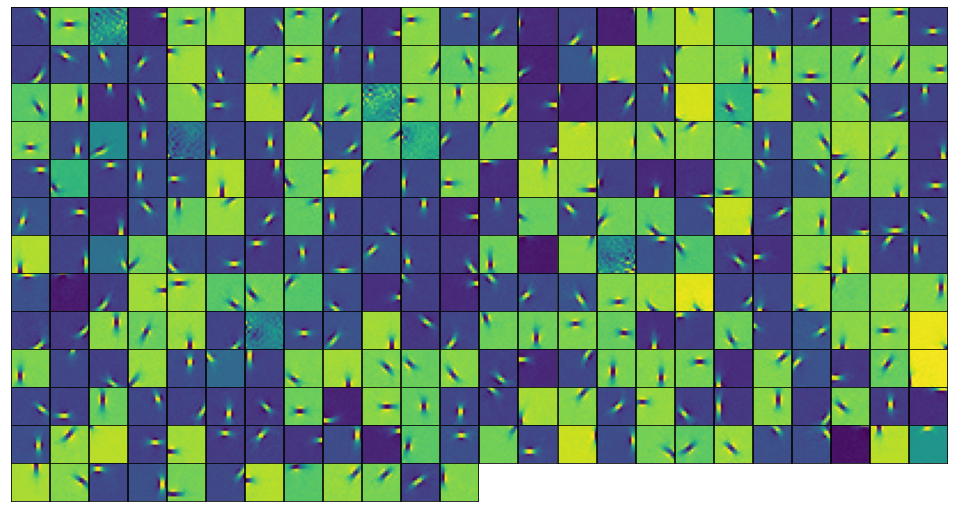

In [26]:
view_results(weight)

Interior Point

Note: like Iterative Ridge, this algorithm is also memory-intensive, so we use a data subset

In [27]:
torch.manual_seed(32)
options = dict(algorithm='interior-point', init='ridge')
weight, losses = dict_learning(
    X_train_sub, 300, alpha=0.5, constrained=True, 
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test_sub, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:37<00:00,  2.15it/s, loss=27.2]


test loss: 30.1566


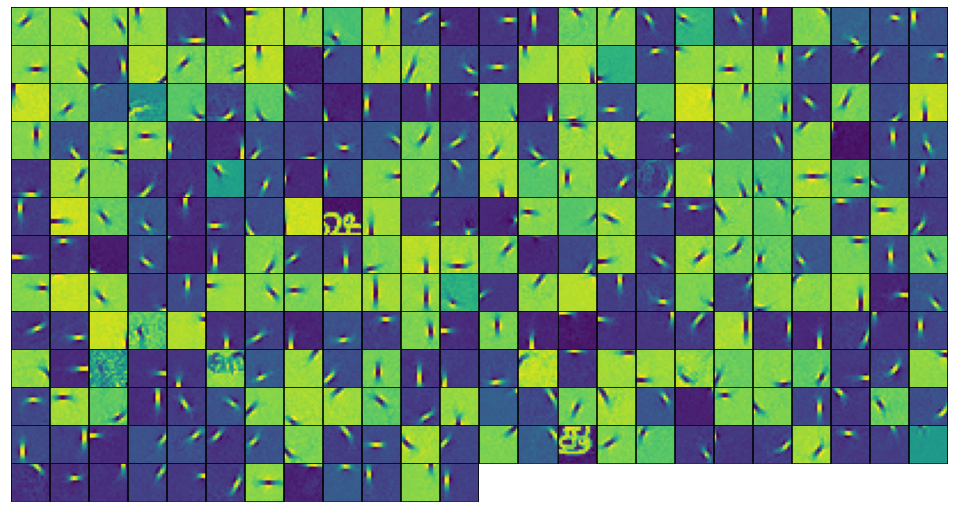

In [28]:
view_results(weight)

# Unconstrained dictionary learning

Iterated Ridge

In [29]:
# IR v1 (conjugate gradient)
torch.manual_seed(32)
options = dict(algorithm='iter-ridge', init='ridge', maxiter=200, 
               cg=True, cg_options=dict(maxiter=200))
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, lambd=2e-2, constrained=False,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:48<00:00,  1.66it/s, loss=19.2]


test loss: 19.4243


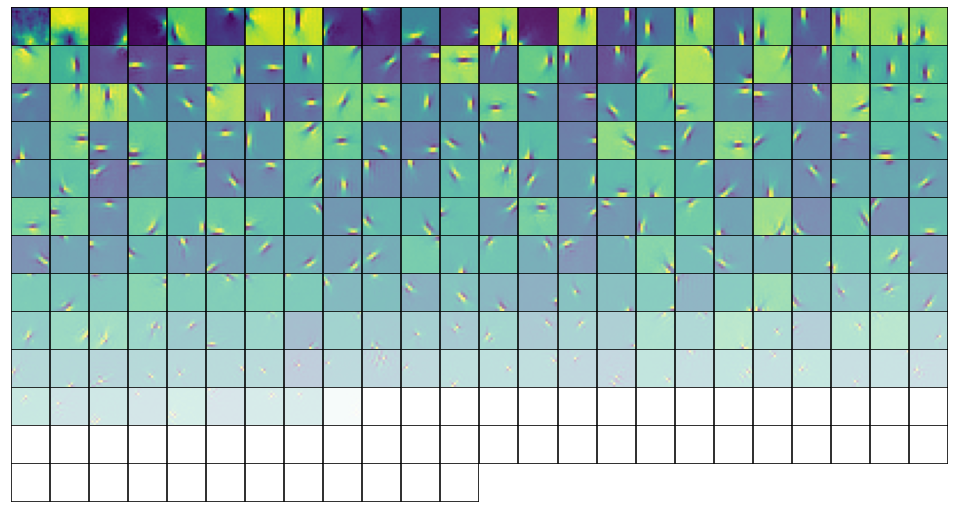

In [30]:
view_results(weight, mag_pct=0.98)

In [31]:
# IR v2 (Cholesky factorization with a data subset)
torch.manual_seed(32)
options = dict(algorithm='iter-ridge', init='ridge', maxiter=200, tikhonov=1e-4)
weight, losses = dict_learning(
    X_train_sub, 300, alpha=0.5, lambd=2e-2, constrained=False,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test_sub, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:17<00:00,  4.50it/s, loss=18.1]


test loss: 20.2500


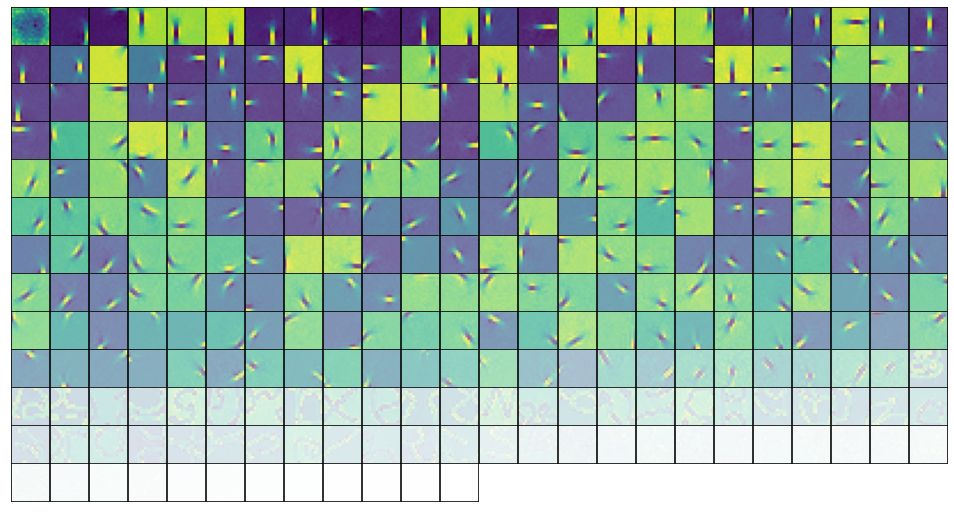

In [32]:
view_results(weight, mag_pct=0.98)

Coordinate Descent

NOTE: The current CD implementation is unreliable. This use case breaks at the moment (although the constrained case works, oddly)

In [43]:
torch.manual_seed(32)
options = dict(algorithm='cd', init='zero', maxiter=200)
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, lambd=2e-2, constrained=False,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

  5%|▌         | 4/80 [00:00<00:17,  4.40it/s, loss=39.8]


RuntimeError: cholesky_cuda: U(2,2) is zero, singular U.

GPSR

In [33]:
torch.manual_seed(32)
options = dict(algorithm='gpsr', init='zero', maxiter=100)
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, lambd=2e-2, constrained=False,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:25<00:00,  3.12it/s, loss=19.8]


test loss: 20.1802


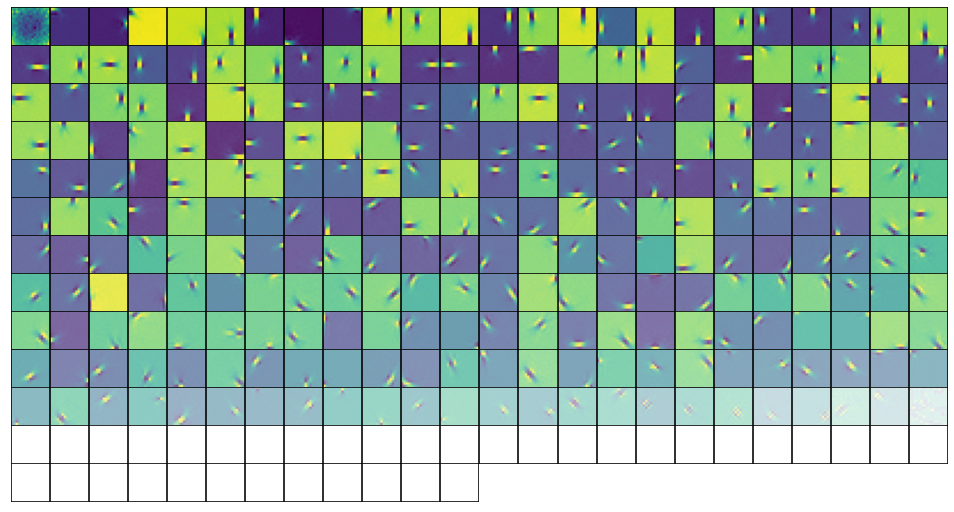

In [34]:
view_results(weight, mag_pct=0.98)

ISTA

In [35]:
torch.manual_seed(32)
options = dict(algorithm='ista', init='ridge', maxiter=20, fast=True, lr='auto')
weight, losses = dict_learning(
    X_train, 300, alpha=0.5, lambd=2e-2, constrained=False,
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:02<00:00, 33.14it/s, loss=20]  


test loss: 20.3467


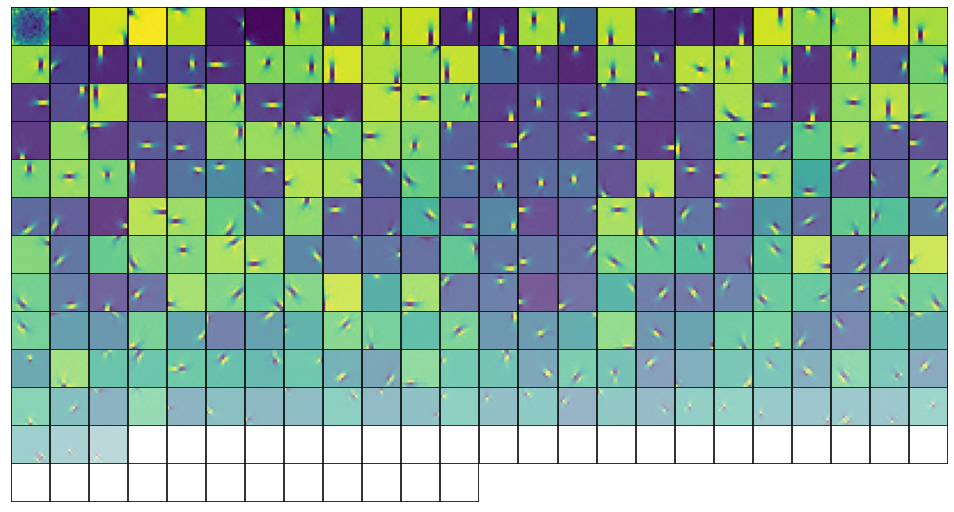

In [36]:
view_results(weight, mag_pct=0.98)

Interior point

In [37]:
torch.manual_seed(32)
options = dict(algorithm='interior-point', init='ridge')
weight, losses = dict_learning(
    X_train_sub, 300, alpha=0.5, lambd=2e-2, constrained=False, 
    device=device, steps=80, **options
)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test_sub, weight, alpha=0.5, **options))

100%|██████████| 80/80 [00:34<00:00,  2.30it/s, loss=19.3]


test loss: 21.5184


/home/feinman/src/pytorch-lasso/lasso/linear/utils.py:60: UserWarning: Cholesky factorization failed. Reverting to LU decomposition...
  warnings.warn('Cholesky factorization failed. Reverting to LU '


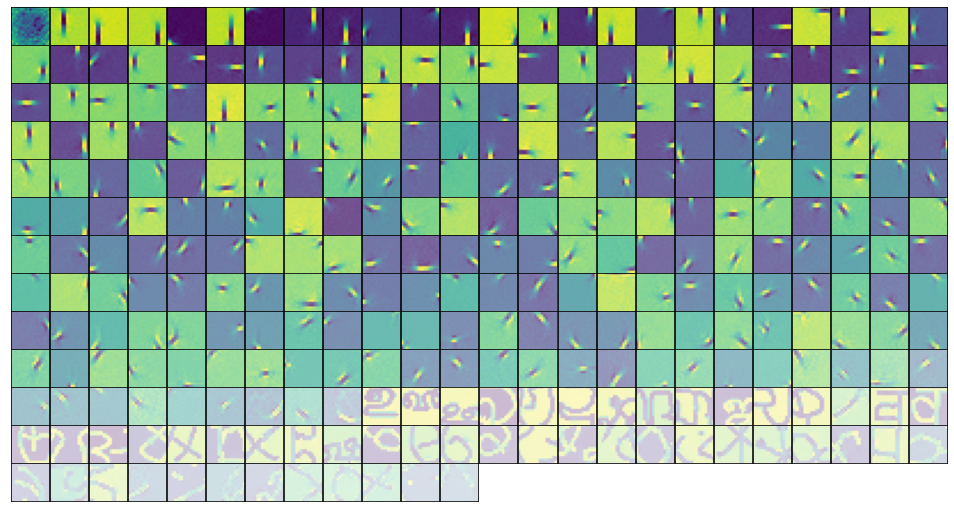

In [38]:
view_results(weight, mag_pct=0.98)